In [1]:
pip install tensorflow-macos  # Apple Silicon için TensorFlowpip install tensorflow-metal  # Metal API ile GPU hızlandırma desteği


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: /Users/filizsayin/gpu_env/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install tensorflow-metal  # Metal API ile GPU hızlandırma desteği


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: /Users/filizsayin/gpu_env/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU available:", len(tf.config.list_physical_devices('GPU')) > 0)

TensorFlow version: 2.16.2
GPU available: True


In [4]:
!pip install seaborn

In [5]:
!pip install pandas

In [6]:
pip install tensorflow==2.16.2 numpy==1.25.0 swifter


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: /Users/filizsayin/gpu_env/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [7]:
import swifter
print("Swifter yüklendi!")

Swifter yüklendi!


/Users/filizsayin/gpu_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
import sys
print(sys.executable)

/Users/filizsayin/gpu_env/bin/python3


## 1- Duygu Analizi (Sentiment Analysis)

#### Gerekli Kütüphanelerin Yüklenmesi

In [11]:
import numpy as np
import pandas as pd
from IPython.display import display, HTML
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import re
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import emoji
from wordcloud import WordCloud
import time
from langdetect import detect, DetectorFactory
from spellchecker import SpellChecker
import spacy
import swifter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import os
import pickle




spell = SpellChecker(language='en')
from joblib import Parallel, delayed
# Ek: Dil tespiti ve yazım düzeltme için


# SpaCy İngilizce modelini yükleyin (ilk kez: !python -m spacy download en_core_web_sm)
nlp_en = spacy.load("en_core_web_sm")


# nltk verilerini indir (ilk kez çalıştırılacak)
nltk.download('stopwords')
nltk.download('wordnet')

# Dil tespiti için sabit seed ayarı (tutarlılık)
DetectorFactory.seed = 0

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/filizsayin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/filizsayin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### 1. Veri Yükleme ve Doğrulama

In [13]:
# Geniş tablo görüntüleme için
pd.set_option('display.max_columns', None)  # Tüm sütunları göster
pd.set_option('display.width', 1000)        # Yatay genişliği artır
pd.set_option('display.colheader_justify', 'center')  # Başlıkları ortala

### All_Beauty Review and Meta

In [15]:
# Dosya yolunu belirtin
file_path = r"/Users/filizsayin/Desktop/Bitirme_Projesi_FilizSayin/All_Beauty.jsonl.gz"

# Dosyayı pandas ile gzip formatında okuyun
df_All_Beauty_Review = pd.read_json(file_path, lines=True, compression='gzip')

df_All_Beauty_Review.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5,Such a lovely scent but not overpowering.,This spray is really nice. It smells really go...,[],B00YQ6X8EO,B00YQ6X8EO,AGKHLEW2SOWHNMFQIJGBECAF7INQ,2020-05-05 14:08:48.923,0,True
1,4,Works great but smells a little weird.,"This product does what I need it to do, I just...",[],B081TJ8YS3,B081TJ8YS3,AGKHLEW2SOWHNMFQIJGBECAF7INQ,2020-05-04 18:10:55.070,1,True
2,5,Yes!,"Smells good, feels great!",[],B07PNNCSP9,B097R46CSY,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ,2020-05-16 21:41:06.052,2,True
3,1,Synthetic feeling,Felt synthetic,[],B09JS339BZ,B09JS339BZ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,2022-01-28 18:13:50.220,0,True
4,5,A+,Love it,[],B08BZ63GMJ,B08BZ63GMJ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,2020-12-30 10:02:43.534,0,True


In [16]:
# Dosya yolunu belirtin
file_path = r"/Users/filizsayin/Desktop/Bitirme_Projesi_FilizSayin/meta_All_Beauty.jsonl.gz"

# Dosyayı pandas ile gzip formatında okuyun
df_All_Beauty_Meta= pd.read_json(file_path, lines=True, compression='gzip')

# DataFrame'in ilk 5 satırını HTML formatında yatay kaydırma çubuğu ile göster
df_All_Beauty_Meta.head()

,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together
0,All Beauty,"Howard LC0008 Leather Conditioner, 8-Ounce (4-...",4.8,10,[],[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],Howard Products,[],{'Package Dimensions': '7.1 x 5.5 x 3 inches; ...,B01CUPMQZE,NaN
1,All Beauty,Yes to Tomatoes Detoxifying Charcoal Cleanser ...,4.5,3,[],[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],Yes To,[],"{'Item Form': 'Powder', 'Skin Type': 'Acne Pro...",B076WQZGPM,NaN
2,All Beauty,Eye Patch Black Adult with Tie Band (6 Per Pack),4.4,26,[],[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],Levine Health Products,[],{'Manufacturer': 'Levine Health Products'},B000B658RI,NaN
3,All Beauty,"Tattoo Eyebrow Stickers, Waterproof Eyebrow, 4...",3.1,102,[],[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],Cherioll,[],"{'Brand': 'Cherioll', 'Item Form': 'Powder', '...",B088FKY3VD,NaN
4,All Beauty,Precision Plunger Bars for Cartridge Grips – 9...,4.3,7,"[Material: 304 Stainless Steel; Brass tip, Len...",[The Precision Plunger Bars are designed to wo...,NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],Precision,[],{'UPC': '644287689178'},B07NGFDN6G,NaN


#### Veri Setinin İncelenmesi

In [18]:
df_All_Beauty_Review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701528 entries, 0 to 701527
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   rating             701528 non-null  int64         
 1   title              701528 non-null  object        
 2   text               701528 non-null  object        
 3   images             701528 non-null  object        
 4   asin               701528 non-null  object        
 5   parent_asin        701528 non-null  object        
 6   user_id            701528 non-null  object        
 7   timestamp          701528 non-null  datetime64[ns]
 8   helpful_vote       701528 non-null  int64         
 9   verified_purchase  701528 non-null  bool          
dtypes: bool(1), datetime64[ns](1), int64(2), object(6)
memory usage: 48.8+ MB


Bu DataFrame, 701.528 satır (örnek) ve 10 sütun içeriyor. Her satır muhtemelen bir ürün yorumu ile ilişkilendirilebilecek bilgileri temsil ediyor. İşte sütunların kısa açıklamaları:

•	rating (int64): Kullanıcının ürüne verdiği puan. (Örneğin 1’den 5’e kadar olabilir.)
•	title (object): Yorumun başlığı.
•	text (object): Yorumun detaylı metni.
•	images (object): Yorumda yer alan görsellerle ilgili bilgiler (muhtemelen URL veya dosya isimleri).
•	asin (object): Ürüne ait benzersiz tanımlayıcı, Amazon Standard Identification Number (ASIN).
•	parent_asin (object): Eğer ürün bir varyasyon içeriyorsa, ana ürünün ASIN numarası olabilir.
•	user_id (object): Yorumu yapan kullanıcının kimliği.
•	timestamp (datetime64[ns]): Yorumun oluşturulduğu tarih ve saat.
•	helpful_vote (int64): Yorumun kaç kişi tarafından faydalı bulunduğunu gösteren oy sayısı.
•	verified_purchase (bool): Ürünün doğrulanmış satın alma olup olmadığını belirten bayrak (True/False).

In [20]:
df_All_Beauty_Meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112590 entries, 0 to 112589
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   main_category    112590 non-null  object 
 1   title            112590 non-null  object 
 2   average_rating   112590 non-null  float64
 3   rating_number    112590 non-null  int64  
 4   features         112590 non-null  object 
 5   description      112590 non-null  object 
 6   price            17704 non-null   float64
 7   images           112590 non-null  object 
 8   videos           112590 non-null  object 
 9   store            101259 non-null  object 
 10  categories       112590 non-null  object 
 11  details          112590 non-null  object 
 12  parent_asin      112590 non-null  object 
 13  bought_together  0 non-null       float64
dtypes: float64(3), int64(1), object(10)
memory usage: 12.0+ MB


Genel Bilgiler

	•	Satır Sayısı (RangeIndex):
	•	Veri setinde 112,590 satır var. Her satır, bir ürün veya inceleme gibi bir veri noktası anlamına geliyor.
	•	Sütun Sayısı:
	•	Veri setinde 14 sütun var. Her sütun, ürünle ilgili farklı bir özelliği temsil ediyor.
	•	Bellek Kullanımı:
	•	Veri seti bellekte yaklaşık 12 MB yer kaplıyor. Bu orta büyüklükte bir veri seti olarak düşünülebilir.

a) main_category (object)
	•	Bu sütun, ürünlerin ana kategorisini temsil eder. Örneğin: “Beauty”, “Skincare” gibi.

b) title (object)
	•	Bu sütun, ürünün başlığını içeriyor. Örneğin: “Moisturizing Cream”, “Hair Shampoo” gibi.

c) average_rating (float64)
	•	Ürünün ortalama kullanıcı puanını ifade eder. Örneğin: 4.5, 3.8 gibi.
	•	Bu sütunun tipi float64, yani ondalık sayılar içeriyor.

d) rating_number (int64)
	•	Bu sütun, bir ürüne verilen toplam oy sayısını gösteriyor. Örneğin: 453, 1200.
	•	Veri türü int64, yani tam sayı içeriyor.

e) features (object)
	•	Ürünün özelliklerini veya teknik detaylarını içeriyor. Bu veri genellikle metin veya JSON formatında olabilir.

f) description (object)
	•	Ürünün açıklamasını içeriyor. Örneğin: Ürünün nasıl kullanılacağı, içerikleri, veya avantajlarını içeren metin bilgisi.

g) price (float64)
	•	17,704 non-null (eksik):
	•	Bu sütunda 94,886 satırda eksik değer (NaN) var.
	•	Bu, ürünlerin büyük bir kısmı için fiyat bilgisinin mevcut olmadığını gösteriyor.
	•	Eksik fiyatlar doldurulabilir (örneğin, ortalama ile) veya fiyatı olmayan ürünler çıkarılabilir.
	•	Veri türü float64, yani fiyatlar ondalıklı sayılar olarak saklanıyor.

h) images (object)
	•	Ürün görsellerinin URL’lerini içeriyor. Bu veri, genellikle liste veya JSON formatında olabilir.

i) videos (object)
	•	Ürün videolarını temsil eden URL’ler içeriyor. Görsel sütununa benzer bir yapı olabilir.

j) store (object)
	•	101,259 non-null:
	•	11,331 satırda eksik değer (NaN) var.
	•	Bu sütun, ürünü satan mağaza bilgisini içeriyor. Eksik mağaza bilgileri doldurulabilir (örneğin, “Unknown” olarak).

k) categories (object)
	•	Ürünün ait olduğu kategorileri içeriyor. Örneğin: [“Beauty”, “Skincare”] gibi bir liste olabilir.

l) details (object)
	•	Ürünün teknik detaylarını içerir. JSON formatında veya metinsel bir veri olabilir.

m) parent_asin (object)
	•	Ürünün “parent ASIN” (Amazon Standart Kimlik Numarası) bilgisi. Varyasyonlar veya alt ürün grupları için kullanılabilir.

n) bought_together (float64)
	•	0 non-null (tamamen eksik):
	•	Bu sütun tamamen boş, yani hiçbir satırda değer içermiyor.
	•	Muhtemelen bu sütun veri setinden kaldırılabilir, çünkü herhangi bir bilgi sağlamıyor.

#### Eksik Değerlerin Analizi

In [24]:
df_All_Beauty_Review.isna().sum()

rating               0
title                0
text                 0
images               0
asin                 0
parent_asin          0
user_id              0
timestamp            0
helpful_vote         0
verified_purchase    0
dtype: int64

In [25]:
df_All_Beauty_Meta.isna().sum()

main_category           0
title                   0
average_rating          0
rating_number           0
features                0
description             0
price               94886
images                  0
videos                  0
store               11331
categories              0
details                 0
parent_asin             0
bought_together    112590
dtype: int64

Eksik Değer Sayıları:
	1.	price: 94,886 eksik değer.
	•	Bu sütun ürün fiyatlarını içeriyor olmalı ve eksik değerler bazı ürünler için fiyat bilgisinin olmadığını gösteriyor.
	•	Bu eksiklik, fiyat analizi yaparken dikkat edilmesi gereken bir durumdur.
	2.	store: 11,331 eksik değer.
	•	Bu sütun, ürünün satışta olduğu mağazaları içeriyor olabilir.
	•	Eksik değerler, ürünlerin belirli mağazalarda bulunmadığını veya mağaza bilgilerinin eksik olduğunu gösterebilir.
	3.	bought_together: 112,590 eksik değer.
	•	Bu sütun, ürünle birlikte satın alınan diğer ürünleri temsil ediyor olabilir.
	•	Eksik değerler, bazı ürünlerin başka bir ürünle birlikte satın alınmadığını gösterebilir.

In [27]:
# Eksik veri oranlarını hesaplama
missing_percentage = df_All_Beauty_Review.isna().sum() / len(df_All_Beauty_Review) * 100
print(missing_percentage)

rating               0.0
title                0.0
text                 0.0
images               0.0
asin                 0.0
parent_asin          0.0
user_id              0.0
timestamp            0.0
helpful_vote         0.0
verified_purchase    0.0
dtype: float64


In [28]:
# Eksik veri oranlarını hesaplama
missing_percentage = df_All_Beauty_Meta.isna().sum() / len(df_All_Beauty_Meta) * 100
print(missing_percentage)

main_category        0.000000
title                0.000000
average_rating       0.000000
rating_number        0.000000
features             0.000000
description          0.000000
price               84.275691
images               0.000000
videos               0.000000
store               10.063949
categories           0.000000
details              0.000000
parent_asin          0.000000
bought_together    100.000000
dtype: float64


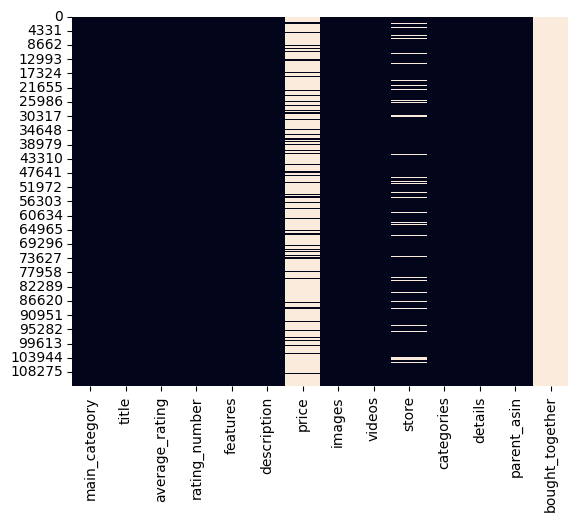

In [29]:
sns.heatmap(df_All_Beauty_Meta.isnull(), cbar=False)
plt.show()

Eksik Verilerin Dağılımı:
	•	price, images, videos, store ve bought_together sütunlarında yoğun şekilde eksik değer bulunmaktadır.
	•	main_category, title, average_rating gibi sütunlar ise genellikle eksiksiz görünmektedir.

### Digital_Music Review and Meta

In [32]:
# Dosya yolunu belirtin
file_path = r"/Users/filizsayin/Desktop/Bitirme_Projesi_FilizSayin/Digital_Music.jsonl.gz"

# Dosyayı pandas ile gzip formatında okuyun
Digital_Music_Review = pd.read_json(file_path, lines=True, compression='gzip')

Digital_Music_Review.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5,Nice,If i had a dollar for how many times I have pl...,[],B004RQ2IRG,B004RQ2IRG,AFUOYIZBU3MTBOLYKOJE5Z35MBDA,2021-04-21 02:36:53.292,0,True
1,5,Excellent,awesome sound - cant wait to see them in perso...,[],B0026UZEI0,B0026UZEI0,AHGAOIZVODNHYMNCBV4DECZH42UQ,2011-06-15 19:52:05.000,0,True
2,5,Great service,This is a great cd. Good music and plays well....,[],B0055JSYHC,B0055JSYHC,AFGEM6BXCYHUILEOA3P2ZYBEF2TA,2021-03-15 20:06:33.006,0,True
3,1,No good,"These are not real German singers, they have a...",[],B000F9SMUQ,B000F9SMUQ,AH3OG6QD6EDJGZRVCFKV4B66VWNQ,2014-07-13 02:49:01.000,0,True
4,3,"Cool concept, so-so execution...",I first heard this playing in a Nagoya shop an...,[],B0049D1WVK,B0049D1WVK,AFW2PDT3AMT4X3PYQG7FJZH5FXFA,2011-06-25 19:19:55.000,0,False


In [33]:
# Dosya yolunu belirtin
file_path = r"/Users/filizsayin/Desktop/Bitirme_Projesi_FilizSayin/meta_Digital_Music.jsonl.gz"

# Dosyayı pandas ile gzip formatında okuyun
Digital_Music_Meta = pd.read_json(file_path, lines=True, compression='gzip')

Digital_Music_Meta.head()

,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together
0,Digital Music,Baja Marimba Band,4.9,8,[],[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],None,[],"{'Date First Available': 'February 28, 2010'}",B000V87RP2,NaN
1,Digital Music,'80s Halloween-All Original Artists & Recordings,5.0,3,[],[],14.98,[{'thumb': 'https://m.media-amazon.com/images/...,[],"Love and Rockets (Artist), Duran Duran (...",[],{'Package Dimensions': '5.55 x 4.97 x 0.54 inc...,B0062F0MJQ,NaN
2,Digital Music,TRIO +1,5.0,1,[],[CD ALBUM],57.99,[{'thumb': 'https://m.media-amazon.com/images/...,[],Rob Wasserman Format: Audio CD,[],"{'Is Discontinued By Manufacturer': 'No', 'Pac...",B00005GT12,NaN
3,Digital Music,"Gold and Silver: Lehar, Delibes, Lanner, Johan...",5.0,1,[],[],29.91,[{'thumb': 'https://m.media-amazon.com/images/...,[],"Franz Lehar (Composer), Leo Delibes (Com...",[],"{'Manufacturer': 'Hungaroton / White Label', '...",B0007PD2BW,NaN
4,Digital Music,Grateful Dead Dave's Picks Volume 25 Live at B...,4.9,20,[],[Sold out. Numbered limited edition],149.99,[{'thumb': 'https://m.media-amazon.com/images/...,[],"Grateful Dead (Artist, Orchestra) Format: ...",[],{'Package Dimensions': '5.55 x 4.97 x 0.54 inc...,B079CPD45R,NaN


In [34]:
Digital_Music_Review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130434 entries, 0 to 130433
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   rating             130434 non-null  int64         
 1   title              130434 non-null  object        
 2   text               130434 non-null  object        
 3   images             130434 non-null  object        
 4   asin               130434 non-null  object        
 5   parent_asin        130434 non-null  object        
 6   user_id            130434 non-null  object        
 7   timestamp          130434 non-null  datetime64[ns]
 8   helpful_vote       130434 non-null  int64         
 9   verified_purchase  130434 non-null  bool          
dtypes: bool(1), datetime64[ns](1), int64(2), object(6)
memory usage: 9.1+ MB


In [35]:
Digital_Music_Meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70537 entries, 0 to 70536
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   main_category    70537 non-null  object 
 1   title            70537 non-null  object 
 2   average_rating   70537 non-null  float64
 3   rating_number    70537 non-null  int64  
 4   features         70537 non-null  object 
 5   description      70537 non-null  object 
 6   price            40125 non-null  float64
 7   images           70537 non-null  object 
 8   videos           70537 non-null  object 
 9   store            66299 non-null  object 
 10  categories       70537 non-null  object 
 11  details          70537 non-null  object 
 12  parent_asin      70537 non-null  object 
 13  bought_together  0 non-null      float64
dtypes: float64(3), int64(1), object(10)
memory usage: 7.5+ MB


In [36]:
Digital_Music_Review.isna().sum()

rating               0
title                0
text                 0
images               0
asin                 0
parent_asin          0
user_id              0
timestamp            0
helpful_vote         0
verified_purchase    0
dtype: int64

In [37]:
Digital_Music_Meta.isna().sum()

main_category          0
title                  0
average_rating         0
rating_number          0
features               0
description            0
price              30412
images                 0
videos                 0
store               4238
categories             0
details                0
parent_asin            0
bought_together    70537
dtype: int64

Digital_Music meta veri setinde gözlemlenen eksik değerler şunlar:
	•	price: 30.412 eksik
	•	store: 4.238 eksik
	•	bought_together: 70.537 eksik

In [39]:
# Eksik veri oranlarını hesaplama
missing_percentage = Digital_Music_Meta.isna().sum() / len(Digital_Music_Meta) * 100
print(missing_percentage)

main_category        0.000000
title                0.000000
average_rating       0.000000
rating_number        0.000000
features             0.000000
description          0.000000
price               43.114961
images               0.000000
videos               0.000000
store                6.008194
categories           0.000000
details              0.000000
parent_asin          0.000000
bought_together    100.000000
dtype: float64


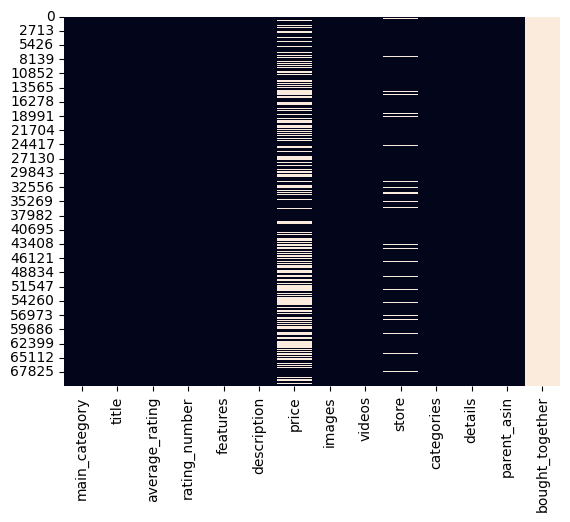

In [40]:
sns.heatmap(Digital_Music_Meta.isnull(), cbar=False)
plt.show()

### Health_and_Personal_Care Review and Meta

In [42]:
# Dosya yolunu belirtin
file_path = r"/Users/filizsayin/Desktop/Bitirme_Projesi_FilizSayin/Health_and_Personal_Care.jsonl.gz"

# Dosyayı pandas ile gzip formatında okuyun
Health_and_Personal_Care_Review  = pd.read_json(file_path, lines=True, compression='gzip')

Health_and_Personal_Care_Review.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,4,12 mg is 12 on the periodic table people! Mg f...,This review is more to clarify someone else’s ...,[],B07TDSJZMR,B07TDSJZMR,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,2020-02-06 00:49:35.902,3,True
1,5,Save the lanet using less plastic.,Love these easy multitasking bleach tablets. B...,[],B08637FWWF,B08637FWWF,AEVWAM3YWN5URJVJIZZ6XPD2MKIA,2020-11-02 22:03:06.880,3,True
2,5,Fantastic,I have been suffering a couple months with hee...,[],B07KJVGNN5,B07KJVGNN5,AHSPLDNW5OOUK2PLH7GXLACFBZNQ,2019-07-24 11:13:58.905,0,True
3,4,It holds the water and makes bubbles. That's ...,"It's cheap and it does what I wanted. The ""ma...",[],B007HY7GC2,B092RP73CX,AEZGPLOYTSAPR3DHZKKXEFPAXUAA,2022-09-04 02:29:02.725,7,True
4,1,Not for me,Didn't do a thing for me. Not saying they don'...,[],B08KYJLF5T,B08KYJLF5T,AEQAYV7RXZEBXMQIQPL6KCT2CFWQ,2022-01-20 23:53:07.262,0,True


In [43]:
# Dosya yolunu belirtin
file_path = r"/Users/filizsayin/Desktop/Bitirme_Projesi_FilizSayin/meta_Health_and_Personal_Care.jsonl.gz"

# Dosyayı pandas ile gzip formatında okuyun
Health_and_Personal_Care_Meta = pd.read_json(file_path, lines=True, compression='gzip')

Health_and_Personal_Care_Meta.head()

,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together
0,Health & Personal Care,Silicone Bath Body Brush Exfoliator Shower Bac...,3.9,7,[],[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],Rzoeox,[],{'Package Dimensions': '15 x 3.3 x 1.5 inches;...,B07V346GZH,NaN
1,Health & Personal Care,"iPhone 7 Plus 8 Plus Screen Protector, ZHXIN T...",3.8,2,[Tough and Robust: Like all 78X screen protect...,[Features: 2.5D Arc Edge Treatment: The edge i...,NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],ZHXIN,[],"{'Brand': 'ZHXIN', 'Compatible Devices': 'Cell...",B075W927RH,NaN
2,Health & Personal Care,Zig Zag Rolling Machine 70mm Size With FREE BO...,3.9,7,[],[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],None,[],{'Package Dimensions': '4.1 x 1.8 x 0.3 inches...,B01FB26VKY,NaN
3,Health & Personal Care,Sting-Kill Disposable Wipes 8 Each ( Pack of 5),4.1,6,[],"[effective on stings and bites from bees, wasp...",21.37,[{'thumb': 'https://m.media-amazon.com/images/...,[],Sting-kill,[],"{'Brand': 'Sting-kill', 'Item Form': 'Wipe', '...",B01IAI29RU,NaN
4,Health & Personal Care,Heated Eyelash Curler Mini Portable Electric E...,3.3,8,[],[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],BiBOSS,[],{'Package Dimensions': '6.1 x 3.1 x 1.9 inches...,B08CMN38RC,NaN


In [44]:
Health_and_Personal_Care_Review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494121 entries, 0 to 494120
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   rating             494121 non-null  int64         
 1   title              494121 non-null  object        
 2   text               494121 non-null  object        
 3   images             494121 non-null  object        
 4   asin               494121 non-null  object        
 5   parent_asin        494121 non-null  object        
 6   user_id            494121 non-null  object        
 7   timestamp          494121 non-null  datetime64[ns]
 8   helpful_vote       494121 non-null  int64         
 9   verified_purchase  494121 non-null  bool          
dtypes: bool(1), datetime64[ns](1), int64(2), object(6)
memory usage: 34.4+ MB


In [45]:
Health_and_Personal_Care_Meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60293 entries, 0 to 60292
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   main_category    60293 non-null  object 
 1   title            60293 non-null  object 
 2   average_rating   60293 non-null  float64
 3   rating_number    60293 non-null  int64  
 4   features         60293 non-null  object 
 5   description      60293 non-null  object 
 6   price            10536 non-null  float64
 7   images           60293 non-null  object 
 8   videos           60293 non-null  object 
 9   store            57947 non-null  object 
 10  categories       60293 non-null  object 
 11  details          60293 non-null  object 
 12  parent_asin      60293 non-null  object 
 13  bought_together  0 non-null      float64
dtypes: float64(3), int64(1), object(10)
memory usage: 6.4+ MB


In [46]:
Health_and_Personal_Care_Review.isna().sum()

rating               0
title                0
text                 0
images               0
asin                 0
parent_asin          0
user_id              0
timestamp            0
helpful_vote         0
verified_purchase    0
dtype: int64

In [47]:
Health_and_Personal_Care_Meta.isna().sum()

main_category          0
title                  0
average_rating         0
rating_number          0
features               0
description            0
price              49757
images                 0
videos                 0
store               2346
categories             0
details                0
parent_asin            0
bought_together    60293
dtype: int64

In [48]:
# Eksik veri oranlarını hesaplama
missing_percentage = Health_and_Personal_Care_Meta.isna().sum() / len(Health_and_Personal_Care_Meta) * 100
print(missing_percentage)

main_category        0.000000
title                0.000000
average_rating       0.000000
rating_number        0.000000
features             0.000000
description          0.000000
price               82.525335
images               0.000000
videos               0.000000
store                3.890999
categories           0.000000
details              0.000000
parent_asin          0.000000
bought_together    100.000000
dtype: float64


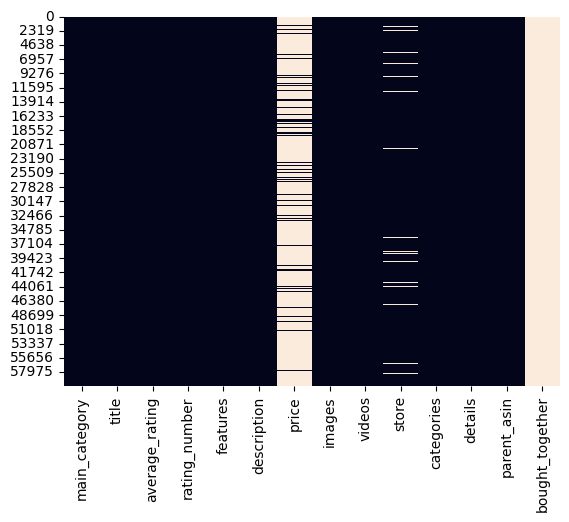

In [49]:
sns.heatmap(Health_and_Personal_Care_Meta.isnull(), cbar=False)
plt.show()

### Duygu Analizi (Sentiment Analysis)

#### Veri Birleştirme,Etiketleme ve Hazırlama

In [52]:
#  Tüm Veri Setlerini Birleştirme:
#Üç  kategoriye ait review veri setleri birleştirme
df_all = pd.concat([df_All_Beauty_Review, Digital_Music_Review, Health_and_Personal_Care_Review], ignore_index=True)

In [53]:
# Duygu Etiketlemesi:
# Rating sütununa göre, rating ≥ 3 ise "pozitif", rating < 3 ise "negatif" etiketi ekleyelim.
df_all['sentiment'] = df_all['rating'].apply(lambda x: 'pozitif' if x >= 3 else 'negatif')


In [54]:
df_all.columns

Index(['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase', 'sentiment'], dtype='object')

In [55]:
# Veriyi Karıştırma:
# Eğer veri seti sıralı veya belirli bir düzen içeriyorsa, önce manuel olarak karıştırmak daha tutarlı bir eğitim-test bölmesi sağlar.
df_all = df_all.sample(frac=1, random_state=42).reset_index(drop=True)
print("Toplam veri sayısı:", df_all.shape)

Toplam veri sayısı: (1326083, 11)


In [56]:
#Train-Test Split:
# Stratified (sentiment dağılımını koruyarak) %80 eğitim, %20 test olacak şekilde bölme yapıyoruz.
train_df, test_df = train_test_split(df_all, test_size=0.2, random_state=42, stratify=df_all['sentiment'])

# Sonuçları Kontrol Edelim:
print("Eğitim seti boyutu:", train_df.shape)
print("Test seti boyutu:", test_df.shape)
print("Eğitim setinden ilk 5 satır:")
print(train_df.head())

Eğitim seti boyutu: (1060866, 11)
Test seti boyutu: (265217, 11)
Eğitim setinden ilk 5 satır:
         rating                       title                                               text                        images     asin    parent_asin            user_id                   timestamp         helpful_vote  verified_purchase sentiment
1131015     5                                             Clippers  My husband loves these clippers, they are much...   []    B00AWD22O2  B00AWD22O2  AFICNOD7NXCJ6HON44QMPELFG6TQ 2014-05-23 13:10:58.000       19              True         pozitif
1159205     5                             Natural looking coverage  I have always strayed away from foundation due...   []    B07JYV4FCQ  B07JYV4FCQ  AEBWGXGGL3Q5DSTMUQSTVUJDWSMA 2021-03-16 16:54:38.832        1             False         pozitif
523649      5    Wonderfully expressive cello interpretations o...  Wonderfully expressive cello interpretations o...   []    B0011DGFEU  B0011DGFEU  AG3RNHHOZ4HLI2K7JM

1.	Veri Seti Boyutu:
Toplamda 1.326.083 satır ve 11 sütun elde ettik. Bu, üç veri setinin birleştirilmesi sonucu beklenen büyüklükte.
	2.	Train-Test Split Oranı:
Eğitim seti 1.060.866 satır, test seti ise 265.217 satır olarak %80-%20 oranında bölünmüş. Bu oran, stratify parametresi kullanılarak duygu etiket dağılımı korunarak yapıldığı için tutarlı.
	3.	Duygu Etiketlemesi:
İlk 5 satırda yer alan yorumların tamamında rating değeri 5 ve sentiment “pozitif” olarak etiketlenmiş. Eğer genel duygu dağılımı da çoğunlukla pozitif ise, bu durum beklenen bir sonuçtur.
	4.	Veri Dağılımı:
Rastgele karıştırma (shuffle) işlemi uygulanmış ve train-test split de stratified şekilde yapıldığı için, verilerin dağılımı da dengeli olmalıdır.

Sonuç olarak, bu adımlara dayanarak elde ettiğimiz çıktı, veri setinin birleştirilmesi, etiketlenmesi ve bölünmesi işlemlerinin doğru ve tutarlı bir şekilde gerçekleştirildiğini gösteriyor. 

In [58]:
print(df_all['sentiment'].value_counts())

sentiment
pozitif    1073215
negatif     252868
Name: count, dtype: int64


Veri dengesizliği var

In [60]:
import sys
print(sys.executable)

/Users/filizsayin/gpu_env/bin/python3


#### Birleştirme ve Duygu Etiketlemesi Sonrası Görselleştirmeler

Aşağıda, üç veri setini birleştirip duygu etiketlemesi (rating ≥ 3 → “pozitif”, rating < 3 → “negatif”) uyguladıktan sonra, verinin rastgele karıştırılmasının (shuffle) ve train-test split işleminin nasıl yapıldığını, ardından bu işlemleri görselleştirme işlemleri yer almaktadır.

Rating Dağılımı (Histogram):

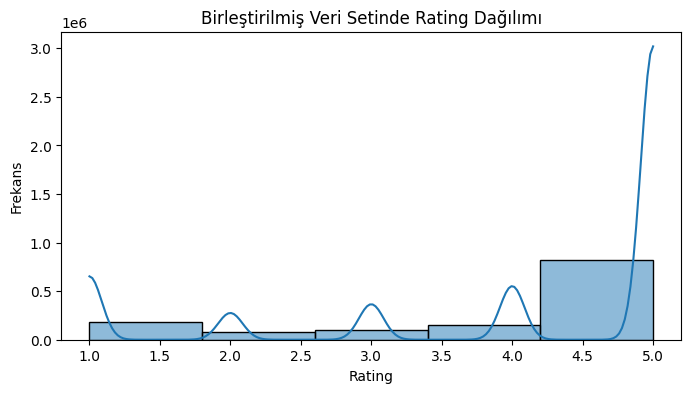

In [64]:
plt.figure(figsize=(8,4))
sns.histplot(df_all['rating'], bins=5, kde=True)
plt.title("Birleştirilmiş Veri Setinde Rating Dağılımı")
plt.xlabel("Rating")
plt.ylabel("Frekans")
plt.show()

    1.	Rating Dağılımı:
	  •	Rating değerleri 1 ile 5 arasında değişmektedir.
	  •	En yüksek yoğunluk, 4.5 ve 5 arasında gözlemlenmektedir. Bu durum, kullanıcıların çoğunlukla yüksek puanlar verdiğini, yani genelde olumlu yorumlar bıraktığını göstermektedir.
	  •	Düşük puanlar (1, 2) çok nadiren verilmiş ve oldukça düşük frekansa sahiptir.
	2.	KDE Eğrisi:
	  •	KDE eğrisi, rating değerlerinin yoğunluklarını daha net bir şekilde gösterir.
	  •	Eğrinin zirvesi 5 civarındadır, bu da kullanıcıların büyük bir kısmının 5 puan verdiğini doğrular.
	3.	Frekans (Y Ekseni):
	  •	Y ekseninde frekans görülmektedir ve en yüksek frekans 3 milyon civarında, bu da veri setinin oldukça büyük olduğunu göstermektedir.
	4.	Rating Aralığı (X Ekseni):
	  •	Rating değerleri 1 ile 5 arasında düzgün bir şekilde gruplandırılmıştır.
	  •	3’ün altındaki puanlar oldukça azdır ve bu, veri setinde daha az olumsuz yorum olduğunu işaret eder.

Sentiment Dağılımı (Count Plot):

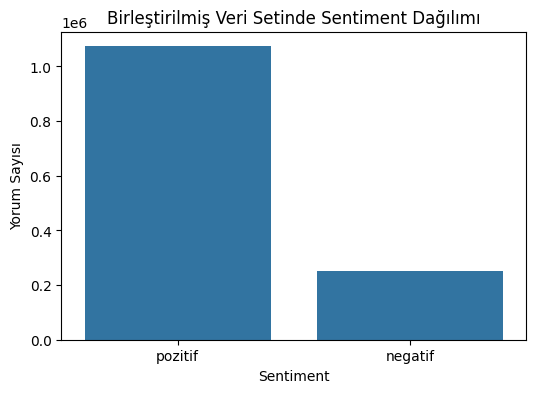

In [67]:
plt.figure(figsize=(6,4))
sns.countplot(data=df_all, x='sentiment')
plt.title("Birleştirilmiş Veri Setinde Sentiment Dağılımı")
plt.xlabel("Sentiment")
plt.ylabel("Yorum Sayısı")
plt.show()

Rating’in Sentimente Göre Dağılımı (Box Plot):

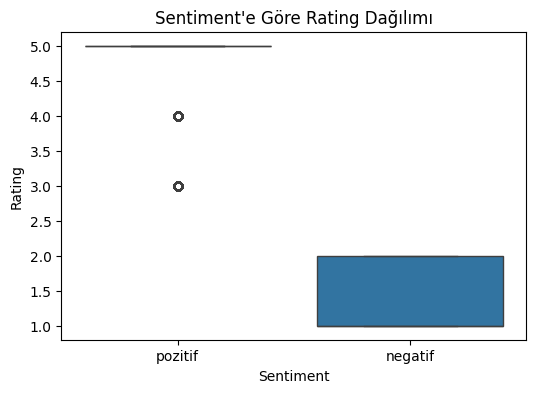

In [69]:
plt.figure(figsize=(6,4))
sns.boxplot(data=df_all, x='sentiment', y='rating')
plt.title("Sentiment'e Göre Rating Dağılımı")
plt.xlabel("Sentiment")
plt.ylabel("Rating")
plt.show()

✅ Sentiment analiz sonuçları ile rating arasında güçlü bir korelasyon var.
✅ Pozitif sentiment → Yüksek rating, Negatif sentiment → Düşük rating ile eşleşiyor.
✅ Ancak bazı pozitif sentiment içeren yorumlar 3-4 rating almış olabilir.
⚠️ Negatif yorumların 3 veya 4 puan almadığı görülüyor, bu yüzden model negatif yorumları çok net sınıflandırıyor olabilir.
💡 Daha dengeli bir dağılım için modelin threshold değerleri ince ayarlanabilir.


#### Shuffle İşlemi Sonrası ve Train-Test Split Sonrası Görselleştirmeler

Veri Setinin Shuffle Edilmiş İlk Satırları:

In [73]:
df_all.columns

Index(['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase', 'sentiment'], dtype='object')

In [74]:
print("Shuffle Edilmiş İlk 10 Satır:")
print(df_all.head(10))

Shuffle Edilmiş İlk 10 Satır:
   rating                     title                                             text                        images     asin    parent_asin            user_id                   timestamp         helpful_vote  verified_purchase sentiment
0     4                   Keeps hair dry while showering                         A little tight on the head   []    B08V16DGX3  B08V16DGX3  AEFHAVRUYZ5GIEXDSBF7SFS5RIBQ 2021-04-20 19:10:03.515        2             True          pozitif
1     5                                       Five Stars   Works great, but would like the end to stay on!!   []    B00UNWA2GC  B00UNWA2GC  AHMF3QY6KHO3O5MC6TMTAD3447GQ 2015-11-19 20:33:03.000        0             True          pozitif
2     5                      Service was great as always  Service was great as always. The product is AW...   []    B007QG7G3U  B007QG7G3U  AG2P4HPA2W42WQOGRX53K6Q2LBVA 2015-08-05 17:12:13.000        0             True          pozitif
3     2                   

📌 Gözlemler:

1️⃣ Veri Shuffle İşlemi Başarıyla Gerçekleştirilmiş
	•	df_all.head(10) çıktısı, veri setinin rastgele karıştırıldığını gösteriyor.
	•	Kullanıcı yorumlarının sırası artık belirli bir düzene bağlı değil.
	•	Modelin overfitting (aşırı öğrenme) yapmasını önlemek için bu önemli bir adım.

2️⃣ Veri Setinin Kolonları Doğru ve Eksiksiz
	•	df_all.columns çıktısına göre veri seti, sentiment analizi ve rating bilgilerini içeriyor:
	•	rating: Kullanıcının verdiği puan
	•	title: Ürün başlığı
	•	text: Kullanıcı yorumu
	•	images: Yorum içeriğinde görüntü olup olmadığı
	•	asin ve parent_asin: Ürün kimlik bilgileri
	•	user_id: Yorum yapan kullanıcı kimliği
	•	timestamp: Yorumun yapıldığı tarih
	•	helpful_vote: Yorumun yardımcı olup olmadığı
	•	verified_purchase: Kullanıcının ürünü gerçekten satın alıp almadığı
	•	sentiment: Yorumun pozitif veya negatif olarak sınıflandırılması

3️⃣ Sentiment Etiketleri ve Rating Değerleri Tutarlı Görünüyor
	•	sentiment etiketi, kullanıcıların verdiği rating ile uyumlu görünüyor.
	•	Pozitif yorumlar genellikle 4-5 rating almış.
	•	Negatif yorumlar genellikle 1-2 rating almış.

4️⃣ Verified Purchase ve Helpful Vote Verileri Mevcut
	•	Model eğitiminde yalnızca doğrulanmış satın alma (verified_purchase=True) ve yüksek helpful_vote alan yorumlar seçilebilir.
	•	Böylece spam yorumları ve güvenilmez verileri eleyebiliriz.

Eğitim Setinde Sentiment Dağılımı (Count Plot):

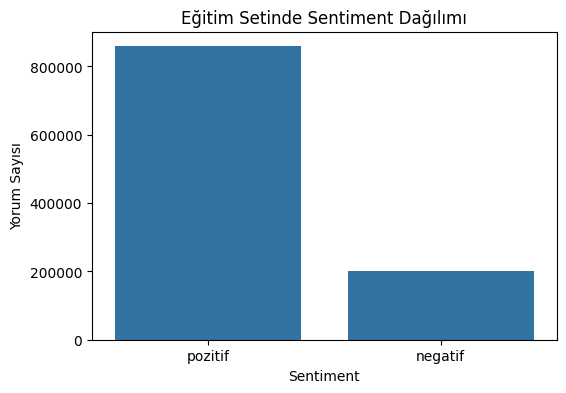

In [77]:
plt.figure(figsize=(6,4))
sns.countplot(data=train_df, x='sentiment')
plt.title("Eğitim Setinde Sentiment Dağılımı")
plt.xlabel("Sentiment")
plt.ylabel("Yorum Sayısı")
plt.show()

Test Setinde Sentiment Dağılımı (Count Plot):

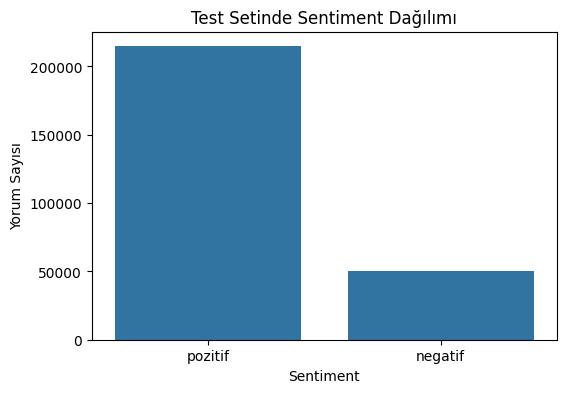

In [79]:
plt.figure(figsize=(6,4))
sns.countplot(data=test_df, x='sentiment')
plt.title("Test Setinde Sentiment Dağılımı")
plt.xlabel("Sentiment")
plt.ylabel("Yorum Sayısı")
plt.show()

### Veri Ön İşleme:

Gerekli Kütüphane ve Kaynakların İçe Aktarılması

In [82]:
# Stop words – Türkçe ve İngilizce
turkish_stopwords = set(stopwords.words('turkish'))
english_stopwords = set(stopwords.words('english'))
combined_stopwords = turkish_stopwords.union(english_stopwords)

# Domain'e özgü stop words (örneğin, Amazon Reviews için)
domain_stopwords = set(['amazon', 'review', 'reviews', 'product', 'item', 'buy', 'purchase', 'verified', 'helpful'])

# Bağlamın korunması için kritik kelimeler (örneğin, "i", "my") – bu kelimeler stop words çıkarma işleminde saklanacak.
preserve_tokens = {"i", "my"}

# Yazım düzeltme için SpellChecker (İngilizce)
spell = SpellChecker(language='en')
lemmatizer = WordNetLemmatizer()


1. Temel Ön İşleme

Bu adımda, HTML temizliği, URL temizliği, küçük harfe dönüştürme ve temel karakter temizliği yapılır.

In [84]:
def remove_html(text):
    """HTML etiketlerini kaldırır."""
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_urls(text):
    """URL'leri ve e-posta adreslerini kaldırır."""
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    return text

def basic_clean(text):
    """Küçük harfe çevirir ve yalnızca alfabe karakterleri ile boşlukları korur."""
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    return re.sub(r'\s+', ' ', text).strip()

def basic_preprocessing(text):
    """Temel ön işleme adımlarını uygular."""
    text = str(text)  # Veriyi stringe çevir
    text = remove_html(text)
    text = remove_urls(text)
    text = basic_clean(text)
    return text

In [85]:
# df_all'in 'text' sütunu orijinal metinleri içeriyor
df_all['clean_text'] = df_all['text'].apply(basic_preprocessing)
print(df_all[['text', 'clean_text']].head(5))

/var/folders/dc/6c3gk9ss6t57mwfnct2fdxhw0000gn/T/ipykernel_8289/2931540732.py:3: MarkupResemblesLocatorWarning: The input passed in on this line looks more like a URL than HTML or XML.

If you meant to use Beautiful Soup to parse the web page found at a certain URL, then something has gone wrong. You should use an Python package like 'requests' to fetch the content behind the URL. Once you have the content as a string, you can feed that string into Beautiful Soup.

However, if you want to parse some data that happens to look like a URL, then nothing has gone wrong: you are using Beautiful Soup correctly, and this warning is spurious and can be filtered. To make this warning go away, run this code before calling the BeautifulSoup constructor:

    from bs4 import MarkupResemblesLocatorWarning
    import warnings

    warnings.filterwarnings("ignore", category=MarkupResemblesLocatorWarning)
    
  soup = BeautifulSoup(text, "html.parser")


                         text                                            clean_text                    
0                         A little tight on the head                         a little tight on the head
1   Works great, but would like the end to stay on!!      works great but would like the end to stay on
2  Service was great as always. The product is AW...  service was great as always the product is awe...
3  Wrong scent delivered. Ok, just not regular pr...  wrong scent delivered ok just not regular product
4  Good Idea<br />In theory however the thymosol ...  good ideain theory however the thymosol which ...


2. Sayısallaştırma (TF-IDF)

Temizlenmiş metinler üzerinden TF-IDF vektörleştirmesi yapar. Burada en sık kullanılan 5000 kelime sınırlandırılmıştır.

In [87]:
from sklearn.feature_extraction.text import TfidfVectorizer

def vectorize_texts(text_series, max_features=5000):
    """
    TF-IDF vektörleştiricisini kullanarak metinleri sayısallaştırır.
    max_features ile en sık kullanılan kelime sayısı sınırlandırılır.
    """
    tfidf_vectorizer = TfidfVectorizer(max_features=max_features, stop_words='english')
    X_tfidf = tfidf_vectorizer.fit_transform(text_series.dropna())
    return X_tfidf, tfidf_vectorizer

In [88]:
X_tfidf, tfidf_vectorizer = vectorize_texts(df_all['clean_text'], max_features=5000)
print("TF-IDF Matrisi Boyutu:", X_tfidf.shape)

TF-IDF Matrisi Boyutu: (1326083, 5000)


Eğitim Seti Üzerinde SMOTE ile Re-sampling Uygulaması

In [90]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import pandas as pd

# Örneğin, df_all üzerinde stratified train-test split yapılmış olsun:
# (Daha önce yaptığınız şekilde)
train_df, test_df = train_test_split(df_all, test_size=0.2, random_state=42, stratify=df_all['sentiment'])

# TF-IDF matrisi tüm veri seti için oluşturulmuştu:
# X_tfidf, tfidf_vectorizer = vectorize_texts(df_all['final_enhanced_clean_text'], max_features=5000)

# Eğitim seti için TF-IDF özelliklerini alalım:
# (Önemli: X_tfidf'nin satırları, df_all'in satırlarıyla aynı indekslere sahip olmalıdır)
X_train = X_tfidf[train_df.index]
y_train = train_df['sentiment']

print("Eğitim setindeki sınıf dağılımı (önce):")
print(pd.Series(y_train).value_counts())

# SMOTE uygulaması
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("SMOTE sonrası eğitim setindeki sınıf dağılımı:")
print(pd.Series(y_train_res).value_counts())

Eğitim setindeki sınıf dağılımı (önce):
sentiment
pozitif    858572
negatif    202294
Name: count, dtype: int64
SMOTE sonrası eğitim setindeki sınıf dağılımı:
sentiment
pozitif    858572
negatif    858572
Name: count, dtype: int64


3. Opsiyonel Gelişmiş Ön İşleme

Eğer temel ön işleme sonrası metinler üzerinde ek iyileştirme yapmak isterseniz (örneğin, lemmatizasyon), aşağıdaki adımları kullanabilirsiniz.

In [93]:
# İlk çalıştırmada gerekli NLTK bileşenlerini indiriyoruz:
nltk.download('stopwords')
nltk.download('wordnet')

def advanced_preprocessing(text):
    """
    Opsiyonel gelişmiş ön işleme: Basit lemmatizasyon işlemi yapar.
    Ek olarak, stop words çıkarma işlemi de gerçekleştirilir.
    """
    lemmatizer = WordNetLemmatizer()
    tokens = text.split()
    english_stop = set(stopwords.words('english'))
    # Stop words olmayan kelimeler üzerinde lemmatizasyon yapıyoruz
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in english_stop]
    return " ".join(tokens)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/filizsayin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/filizsayin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [94]:
# Temel ön işleme sonrası metni gelişmiş işleme sokmak isterseniz:
df_all['advanced_text'] = df_all['clean_text'].apply(advanced_preprocessing)
print(df_all[['clean_text', 'advanced_text']].head(5))

                      clean_text                                       advanced_text                   
0                         a little tight on the head                                  little tight head
1      works great but would like the end to stay on                     work great would like end stay
2  service was great as always the product is awe...  service great always product awesome smell gre...
3  wrong scent delivered ok just not regular product           wrong scent delivered ok regular product
4  good ideain theory however the thymosol which ...  good ideain theory however thymosol antiseptic...


📊 Gözlemler:

1️⃣ Stopword’lerin Kaldırılması
	•	english_stop = set(stopwords.words('english')) satırı ile önemsiz kelimeler (stopwords) filtreleniyor.
	•	Örneğin, “a”, “is”, “the”, “on” gibi bağlaç ve zamirler kaldırılıyor.

2️⃣ Lemmatization (Kelimelerin Köklerine İndirgenmesi)
	•	WordNetLemmatizer() ile kelimeler temel formlarına indirgeniyor.
	•	Örneğin:
	•	“working” → “work”
	•	“running” → “run”
	•	“better” → “good”
	•	Bu işlem, metinlerdeki kelimelerin farklı varyasyonlarının aynı kelime olarak algılanmasını sağlıyor.

	•	Farklar:
	•	“a”, “the”, “on” gibi stopword’ler kaldırılmış.
	•	“works” → “work” gibi kelimeler köklerine indirgenmiş.


### LSTM Modeli

In [97]:
import tensorflow as tf
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [98]:
# ======================= 📌 Veri Yükleme ======================= #
# df_all veri çerçevesi mevcut kabul edilmiştir.

# Tokenizasyon ve Padding
max_words = 10000
maxlen = 100
embedding_dim = 100

# Tokenizer
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df_all['advanced_text'])

# Metinleri dizilere dönüştürme
sequences = tokenizer.texts_to_sequences(df_all['advanced_text'])
padded_sequences = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')

# Hedef değişken
labels = df_all['sentiment']  # 0 veya 1

# Eğitim ve test setlerini ayırma
train_df, test_df = train_test_split(df_all, test_size=0.2, random_state=42, stratify=df_all['sentiment'])

# Tokenizasyon ve Padding (Eğitim verisi)
sequences_train = tokenizer.texts_to_sequences(train_df['advanced_text'])
X_train = pad_sequences(sequences_train, maxlen=maxlen, padding='post', truncating='post')

# Test Seti Tokenizasyon ve Padding
X_test = tokenizer.texts_to_sequences(test_df['advanced_text'])
X_test = pad_sequences(X_test, maxlen=maxlen, padding='post', truncating='post')

# Etiketleri Sayısallaştırma
label_mapping = {'pozitif': 1, 'negatif': 0}
y_train = np.array(train_df['sentiment'].map(label_mapping))
y_test = np.array(test_df['sentiment'].map(label_mapping))

# SMOTE Uygulaması (Tam Denge)
smote = SMOTE(sampling_strategy=1.0, random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Veri Türlerini Ayarlama
X_train = np.array(X_train_res, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)
y_train = np.array(y_train_res, dtype=np.int32)
y_test = np.array(y_test, dtype=np.int32)

# Sınıf Ağırlıkları Hesaplama
class_weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

# ======================= 📌 Focal Loss ======================= #
import tensorflow.keras.backend as K

def focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        y_true = K.cast(y_true, K.floatx())
        y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
        pt = tf.where(K.equal(y_true, 1), y_pred, 1 - y_pred)
        return -K.mean(alpha * K.pow(1. - pt, gamma) * K.log(pt))
    return loss

# ======================= 📌 Model ve Tokenizer Kontrolü ======================= #
if os.path.exists('lstm_sentiment_model.keras') and os.path.exists('tokenizer.pkl'):
    # Modeli ve Tokenizer'ı yükle
    model = tf.keras.models.load_model('lstm_sentiment_model.keras', compile=False)
    with open('tokenizer.pkl', 'rb') as file:
        tokenizer = pickle.load(file)
    print("✅ LSTM Modeli ve Tokenizer yüklendi. Eğitim atlandı.")
    model.summary()

# ======================= 📌 Eğitim Aşaması ======================= #
else:
    # Eğitim işlemleri burada yapılır
    print("⚠️ Model dosyası bulunamadı. Eğitim başlatılıyor...")

    # LSTM Modeli (2 Katmanlı Bidirectional)
    model = Sequential()
    model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=maxlen))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Bidirectional(LSTM(32, return_sequences=False)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    # Model Derleme
    from tensorflow.keras.optimizers import Adam
    optimizer = Adam(learning_rate=0.0003)
    model.compile(loss=focal_loss(), optimizer=optimizer, metrics=['accuracy'])

    # Model Özeti
    model.summary()

    # Early Stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Eğitim
    history = model.fit(X_train, y_train, epochs=15, batch_size=64, validation_data=(X_test, y_test),
                        class_weight=class_weight_dict, callbacks=[early_stopping])

    # Model ve Tokenizer'ı kaydetme
    model.save('lstm_sentiment_model.keras')
    with open('tokenizer.pkl', 'wb') as file:
        pickle.dump(tokenizer, file)
    print("✅ Model ve Tokenizer kaydedildi.")

    # Eğitim ve Doğrulama Grafikleri
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# ======================= 📌 Performans Değerlendirme ======================= #
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


2025-03-01 22:13:05.991050: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2025-03-01 22:13:05.991075: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2025-03-01 22:13:05.991078: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2025-03-01 22:13:05.991296: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-01 22:13:05.991305: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


✅ LSTM Modeli ve Tokenizer yüklendi. Eğitim atlandı.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 100, 128)       │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,125,761 (4.29 MB)

 Trainable params: 1,125,761 (4.29 MB)

 Non-trainable params: 0 (0.00 B)

   1/8289 ━━━━━━━━━━━━━━━━━━━━ 36:20 263ms/step

2025-03-01 22:13:06.601154: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


8289/8289 ━━━━━━━━━━━━━━━━━━━━ 252s 30ms/step
              precision    recall  f1-score   support

           0       0.70      0.79      0.74     50574
           1       0.95      0.92      0.93    214643

    accuracy                           0.89    265217
   macro avg       0.82      0.85      0.84    265217
weighted avg       0.90      0.89      0.90    265217

[[ 39861  10713]
 [ 17425 197218]]


LSTM Kaydetme

In [100]:
from tensorflow.keras.models import load_model

# Önceden kaydedilen .h5 dosyasını yükleyin
model = load_model('lstm_sentiment_model.h5', compile=False)
print("LSTM Model başarıyla .h5 dosyasından yüklendi.")

# Yeni .keras formatında kaydedin
model.save('lstm_sentiment_model.keras')
print("LSTM Model başarıyla .keras formatında kaydedildi.")

LSTM Model başarıyla .h5 dosyasından yüklendi.
LSTM Model başarıyla .keras formatında kaydedildi.


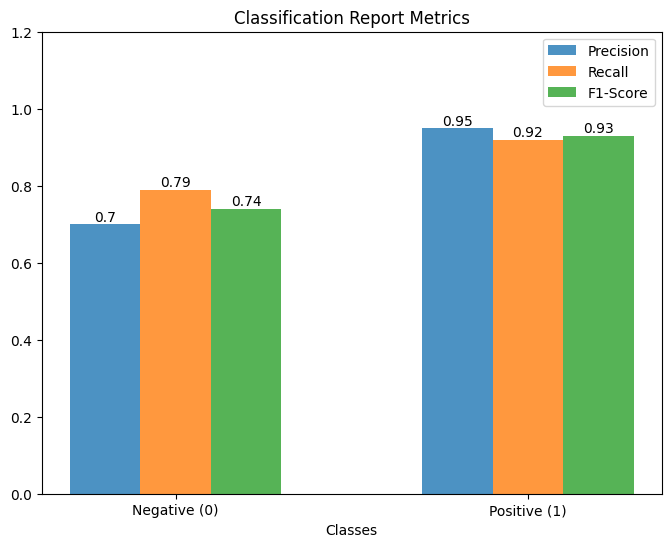

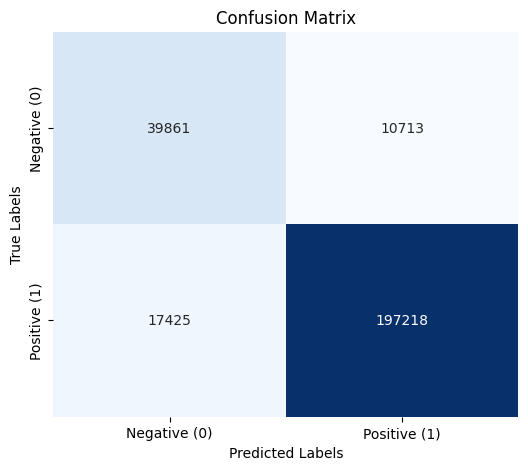

In [101]:
# Classification report metrics
labels = ['Negative (0)', 'Positive (1)']
precision = [0.70, 0.95]
recall = [0.79, 0.92]
f1_score = [0.74, 0.93]
support = [50574, 214643]

# Bar plot - Precision, Recall, F1-Score
fig, ax = plt.subplots(figsize=(8, 6))
bar_width = 0.2
index = np.arange(len(labels))

# Create bars
bars1 = ax.bar(index, precision, bar_width, label='Precision', alpha=0.8)
bars2 = ax.bar(index + bar_width, recall, bar_width, label='Recall', alpha=0.8)
bars3 = ax.bar(index + bar_width * 2, f1_score, bar_width, label='F1-Score', alpha=0.8)

# Labels and titles
ax.set_xlabel('Classes')
ax.set_title('Classification Report Metrics')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(labels)
ax.set_ylim(0, 1.2)
ax.legend()

# Display values on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

plt.show()

# Confusion matrix heatmap
conf_matrix = np.array([[39861, 10713], [17425, 197218]])
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=labels, yticklabels=labels)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')

plt.show()

📊 Model Performans Değerlendirmesi

1️⃣ Classification Report Metrics (Sınıflandırma Raporu Metrikleri)

Bu grafikte, Precision (Kesinlik), Recall (Duyarlılık) ve F1-Score değerleri sınıflar bazında gösterilmektedir.
	•	Negative Class (0 - Olumsuz)
	•	Precision: 0.70 → Model, negatif tahminlerinin %70’ini doğru yapmış.
	•	Recall: 0.79 → Gerçek negatiflerin %79’unu doğru tahmin etmiş.
	•	F1-Score: 0.74 → Precision ve Recall arasında dengeli bir başarı gösteriyor.
	•	Positive Class (1 - Olumlu)
	•	Precision: 0.95 → Modelin olumlu tahminlerinin %95’i doğru.
	•	Recall: 0.92 → Gerçek olumlu yorumların %92’si doğru tahmin edilmiş.
	•	F1-Score: 0.93 → Olumlu yorumları ayırt etmede oldukça başarılı.

Genel Yorum:
✔ Model olumlu sınıflandırmada oldukça iyi çalışıyor.
✔ Negatif sınıflandırmada ise Recall (0.79) Precision’dan (0.70) daha yüksek, yani model negatif yorumları tespit etmede daha iyi ama yanlış pozitif tahmin yapma oranı biraz fazla.

2️⃣ Confusion Matrix (Karışıklık Matrisi)

Bu matris, modelin gerçek etiketler ile tahminlerini karşılaştırır:
	•	39861 → Gerçekten negatif olan ve doğru tahmin edilen örnekler (True Negative - TN)
	•	10713 → Gerçekte negatif olup yanlışlıkla pozitif tahmin edilenler (False Positive - FP)
	•	17425 → Gerçekte pozitif olup yanlışlıkla negatif tahmin edilenler (False Negative - FN)
	•	197218 → Gerçekten pozitif olan ve doğru tahmin edilen örnekler (True Positive - TP)

Genel Değerlendirme:
✔ Model, pozitif yorumları çok iyi tahmin ediyor.
⚠ Ancak, 17425 yanlış negatif tahmin yüksek görünüyor, yani bazı pozitif yorumlar yanlışlıkla negatif olarak sınıflandırılmış.
⚠ Negatif sınıfın precision değeri düşük, yani negatif tahminlerde biraz hata payı var.

Eğitim ve Doğrulama Grafikleri

In [199]:
# Eğitim sonrası grafiklerin kaydedilmesi
if 'history' in locals() and history.history.get('accuracy'):
    # Eğitim geçmişini kaydetme
    with open('training_history.pkl', 'wb') as file:
        pickle.dump(history.history, file)
    print("✅ Eğitim geçmişi başarıyla kaydedildi.")

    # Accuracy Grafiği
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.savefig('accuracy_plot.png')  # Grafik dosyasını kaydet
    plt.show()

    # Loss Grafiği
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.savefig('loss_plot.png')  # Grafik dosyasını kaydet
    plt.show()

In [184]:
# Eğitim geçmişini yükleme ve grafiklerin çizilmesi
import pickle
import matplotlib.pyplot as plt

try:
    with open('training_history.pkl', 'rb') as file:
        history_data = pickle.load(file)
    print("✅ Eğitim geçmişi başarıyla yüklendi.")

    # Accuracy Grafiği
    plt.figure(figsize=(8, 6))
    plt.plot(history_data['accuracy'], label='Training Accuracy')
    plt.plot(history_data['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

    # Loss Grafiği
    plt.figure(figsize=(8, 6))
    plt.plot(history_data['loss'], label='Training Loss')
    plt.plot(history_data['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

except FileNotFoundError:
    print("⚠️ Eğitim geçmişi bulunamadı. Eğitim yapıldıktan sonra grafikler gösterilecektir.")

⚠️ Eğitim geçmişi bulunamadı. Eğitim yapıldıktan sonra grafikler gösterilecektir.


Logistic Regression

In [107]:
# ======================= 📌 Logistic Regression ======================= #
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight

# Özellikler ve Etiketler
X = X_train
y = y_train

# Eğitim ve Test Setlerini Ayırma
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X, y, test_size=0.2, random_state=42)

# Sınıf Ağırlıklarını Hesaplama
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_lr), y=y_train_lr)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

# Logistic Regression Modeli
model_lr = LogisticRegression(class_weight=class_weight_dict, max_iter=1000, solver='lbfgs')
model_lr.fit(X_train_lr, y_train_lr)

# Performans Değerlendirme
y_pred_lr = model_lr.predict(X_test_lr)
print(classification_report(y_test_lr, y_pred_lr))
print(confusion_matrix(y_test_lr, y_pred_lr))

              precision    recall  f1-score   support

           0       0.57      0.54      0.56    171643
           1       0.57      0.60      0.58    171786

    accuracy                           0.57    343429
   macro avg       0.57      0.57      0.57    343429
weighted avg       0.57      0.57      0.57    343429

[[ 92507  79136]
 [ 68849 102937]]


📊 Logistic Regression Model Performansı

1️⃣ Classification Report Metrics (Sınıflandırma Raporu Metrikleri)

Bu model, iki sınıfı (0: Negatif, 1: Pozitif) sınıflandırmak için Logistic Regression kullanıyor. Aşağıda Precision (Kesinlik), Recall (Duyarlılık) ve F1-Score değerlerini inceleyelim:
	•	Negative Class (0 - Olumsuz)
	•	Precision (Kesinlik): 0.57 → Negatif tahminlerin %57’si doğru.
	•	Recall (Duyarlılık): 0.54 → Gerçek negatiflerin %54’ü doğru tahmin edilmiş.
	•	F1-Score: 0.56 → Precision ve Recall’un dengesi fena değil ama çok yüksek değil.
	•	Positive Class (1 - Olumlu)
	•	Precision: 0.57 → Olumlu tahminlerin %57’si doğru.
	•	Recall: 0.60 → Gerçek pozitiflerin %60’ı doğru tahmin edilmiş.
	•	F1-Score: 0.58 → Model, pozitif sınıfı biraz daha iyi ayırt edebiliyor.
	•	Genel Performans
	•	Accuracy (Doğruluk): 0.57 → Model genel olarak verilerin %57’sini doğru tahmin edebilmiş.
	•	Macro Avg: 0.57 → Sınıflar arasındaki ortalama performans.
	•	Weighted Avg: 0.57 → Veri dağılımına göre ağırlıklı ortalama.

     Confusion Matrix (Karışıklık Matrisi)
     
    •	True Negative (92,507): Model, 92,507 adet negatif yorumun negatif olduğunu doğru tahmin etmiş.
	•	False Positive (79,136): 79,136 negatif yorum yanlışlıkla pozitif olarak tahmin edilmiş.
	•	False Negative (68,849): 68,849 pozitif yorum yanlışlıkla negatif olarak tahmin edilmiş.
	•	True Positive (102,937): Model, 102,937 pozitif yorumu doğru tahmin etmiş.


Random Forest 

In [109]:
# ======================= 📌 Random Forest ======================= #
from sklearn.ensemble import RandomForestClassifier

# Random Forest Modeli
model_rf = RandomForestClassifier(n_estimators=50, max_depth=20, random_state=42, class_weight='balanced_subsample')
model_rf.fit(X_train_lr, y_train_lr)

# Performans Değerlendirme
y_pred_rf = model_rf.predict(X_test_lr)
print(classification_report(y_test_lr, y_pred_rf))
print(confusion_matrix(y_test_lr, y_pred_rf))

              precision    recall  f1-score   support

           0       0.71      0.80      0.75    171643
           1       0.77      0.67      0.72    171786

    accuracy                           0.74    343429
   macro avg       0.74      0.74      0.74    343429
weighted avg       0.74      0.74      0.74    343429

[[137785  33858]
 [ 56475 115311]]


1️⃣ Classification Report Metrics (Sınıflandırma Raporu Metrikleri)

Negatif Sınıf (0 - Olumsuz)
	•	Precision (Kesinlik): 0.71 → Modelin negatif tahminlerinin %71’i doğru.
	•	Recall (Duyarlılık): 0.80 → Gerçek negatiflerin %80’i doğru tahmin edilmiş.
	•	F1-Score: 0.75 → Precision ve Recall dengesine göre ortalama iyi bir performans var.

Pozitif Sınıf (1 - Olumlu)
	•	Precision: 0.77 → Modelin pozitif tahminlerinin %77’si doğru.
	•	Recall: 0.67 → Gerçek pozitiflerin %67’si doğru tahmin edilmiş. (Bu biraz daha düşük)
	•	F1-Score: 0.72 → Genel olarak olumlu yorumları da iyi yakalıyor ama recall biraz düşük.

Genel Model Performansı
	•	Accuracy (Doğruluk): 0.74 → Model %74 doğruluk oranına sahip.
	•	Macro Avg (Makro Ortalama): 0.74 → Tüm sınıflar arasında eşit ağırlıklı ortalama.
	•	Weighted Avg (Ağırlıklı Ortalama): 0.74 → Veri dağılımına göre ağırlıklı ortalama.

2️⃣ Confusion Matrix (Karışıklık Matrisi)

	•	True Negative (137,785): Model 137,785 negatif yorumun negatif olduğunu doğru tahmin etmiş.
	•	False Positive (33,858): 33,858 negatif yorum yanlışlıkla pozitif olarak tahmin edilmiş.
	•	False Negative (56,475): 56,475 pozitif yorum yanlışlıkla negatif olarak tahmin edilmiş.
	•	True Positive (115,311): Model 115,311 pozitif yorumu doğru tahmin etmiş.

Dikkat Çeken Noktalar:
✔ Negatif yorumları ayırt etme oranı (recall: 0.80) oldukça yüksek.
⚠ Ancak pozitif yorumları yakalama oranı (recall: 0.67) biraz daha düşük.
⚠ False Negative (Yanlış Negatif) değeri biraz yüksek. Model bazı pozitif yorumları kaçırıyor.

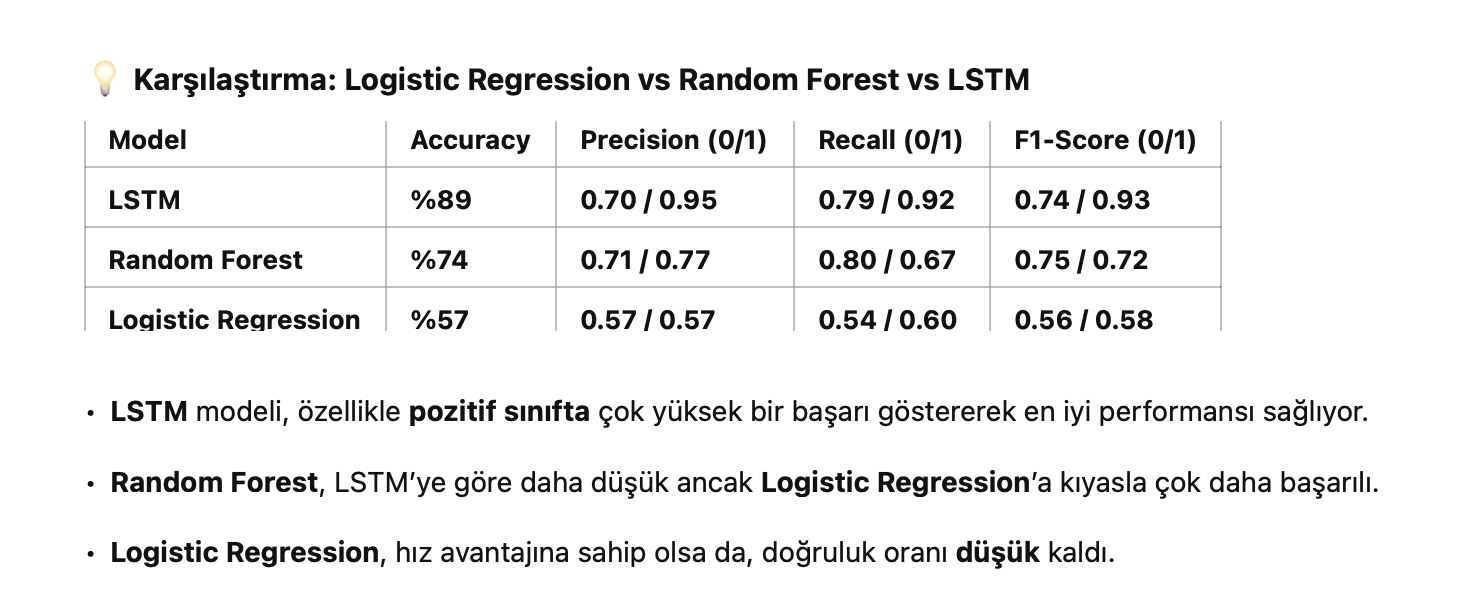

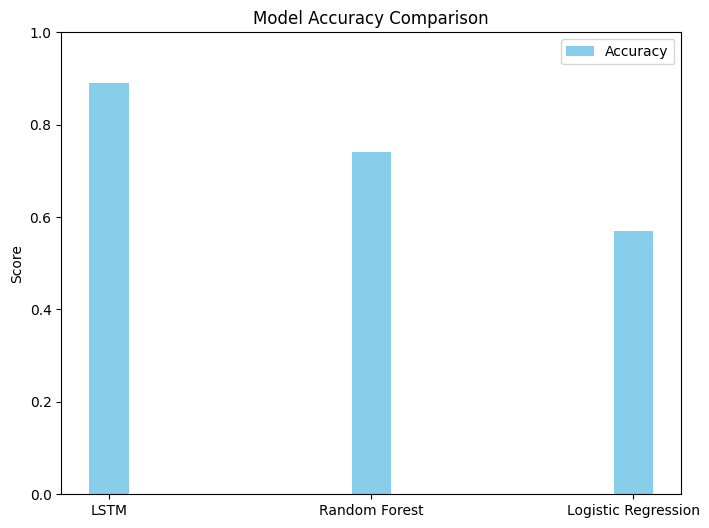

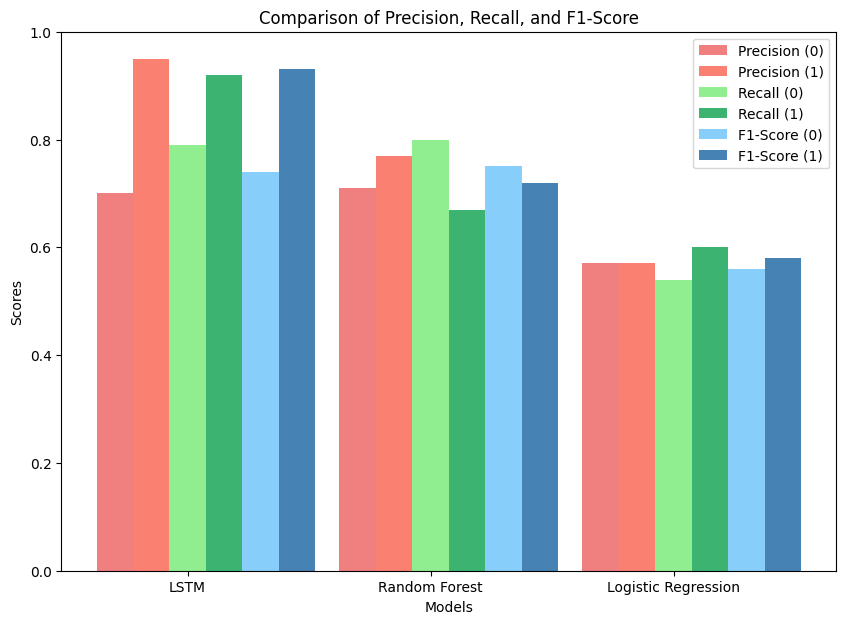

In [190]:
# Model sonuçları
models = ['LSTM', 'Random Forest', 'Logistic Regression']
accuracy = [0.89, 0.74, 0.57]
precision_0 = [0.70, 0.71, 0.57]
precision_1 = [0.95, 0.77, 0.57]
recall_0 = [0.79, 0.80, 0.54]
recall_1 = [0.92, 0.67, 0.60]
f1_0 = [0.74, 0.75, 0.56]
f1_1 = [0.93, 0.72, 0.58]

# Grafiklerin çizimi
x = np.arange(len(models))
bar_width = 0.15

# Accuracy Grafiği
plt.figure(figsize=(8, 6))
plt.bar(x, accuracy, bar_width, label='Accuracy', color='skyblue')
plt.xticks(x, models)
plt.ylabel('Score')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1)
plt.legend()
plt.show()

# Precision, Recall, F1-Score Grafikleri
fig, ax = plt.subplots(figsize=(10, 7))
ax.bar(x - 2 * bar_width, precision_0, bar_width, label='Precision (0)', color='lightcoral')
ax.bar(x - bar_width, precision_1, bar_width, label='Precision (1)', color='salmon')
ax.bar(x, recall_0, bar_width, label='Recall (0)', color='lightgreen')
ax.bar(x + bar_width, recall_1, bar_width, label='Recall (1)', color='mediumseagreen')
ax.bar(x + 2 * bar_width, f1_0, bar_width, label='F1-Score (0)', color='lightskyblue')
ax.bar(x + 3 * bar_width, f1_1, bar_width, label='F1-Score (1)', color='steelblue')

ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Precision, Recall, and F1-Score')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim(0, 1)
ax.legend()
plt.show()

1️⃣ Model Accuracy Comparison (Model Doğruluk Karşılaştırması)

Üstteki grafik modellerin doğruluk (accuracy) skorlarını göstermektedir:

✔ LSTM modeli en yüksek doğruluğa sahip (~%88-90 civarı).

✔ Random Forest doğruluk açısından ikinci sırada (~%74).

✔ Logistic Regression en düşük doğruluğa sahip (~%57).

🚀 Sonuç: LSTM modeli diğer modellere kıyasla çok daha başarılı bir şekilde çalışıyor.


2️⃣ Precision, Recall ve F1-Skor Karşılaştırması

Alttaki grafik pozitif (1) ve negatif (0) sınıflar için Precision, Recall ve F1-Skorlarını göstermektedir.

🔹 LSTM Modeli

✔ Precision, Recall ve F1-Skoru hem pozitif hem de negatif sınıf için en yüksek seviyede.
✔ Özellikle Pozitif sınıfta (1) çok yüksek performans sergiliyor (~%90+).

🔹 Random Forest Modeli

✔ Orta seviyede bir performans gösteriyor.
✔ Negatif (0) sınıfta recall yüksek (%80), ancak pozitif sınıfta biraz düşüş var (%67).

🔹 Logistic Regression Modeli

⚠ En düşük performansa sahip.
⚠ Precision, Recall ve F1-Skorları hem pozitif hem de negatif sınıfta düşük (~%57 civarı).

📌 Genel Sonuçlar

✔ LSTM modeli açık ara en başarılı modeldir.
✔ Random Forest, Logistic Regression’a göre daha iyi, ancak LSTM kadar güçlü değil.
✔ Logistic Regression doğruluk oranı düşük olduğundan bu problem için uygun değil.

🎯 Genel Değerlendirme

💡 LSTM modeli duygu analizi için en uygun modeldir ve en yüksek performansı göstermektedir.
💡 Eğer hız önemliyse, Random Forest iyi bir alternatif olabilir.
💡 Logistic Regression, basit modeller için bir temel olarak kullanılabilir ancak bu problem için yeterli değil. 🚀

### Görsel Analiz

Veri Hazırlama

In [114]:
# Örnek: Kategorilere göre metinlerin birleştirilmesi
df_positive = df_all[df_all['sentiment'] == 'pozitif']['advanced_text'].str.cat(sep=' ')
df_negative = df_all[df_all['sentiment'] == 'negatif']['advanced_text'].str.cat(sep=' ')

Word Cloud Oluşturma

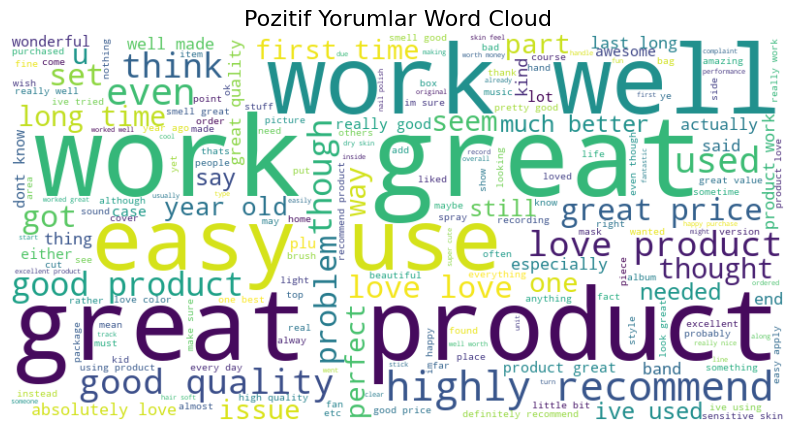

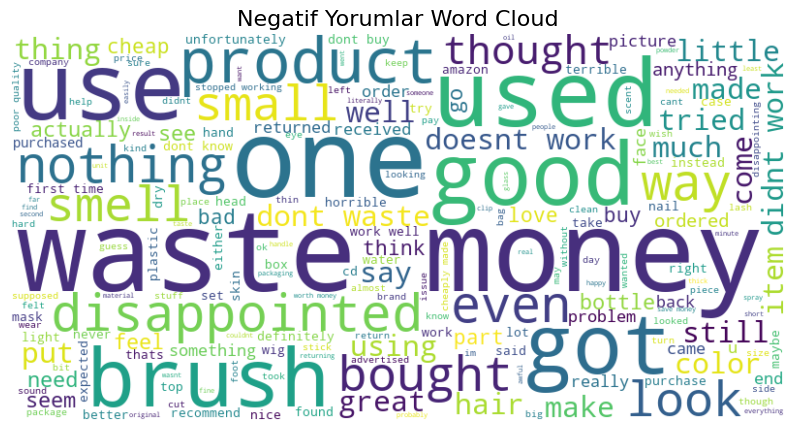

In [116]:
def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

# Pozitif Yorumlar Word Cloud
plot_wordcloud(df_positive, 'Pozitif Yorumlar Word Cloud')

# Negatif Yorumlar Word Cloud
plot_wordcloud(df_negative, 'Negatif Yorumlar Word Cloud')

 Kategorilere Göre Word Cloud (Her Kategori için Ayrı)

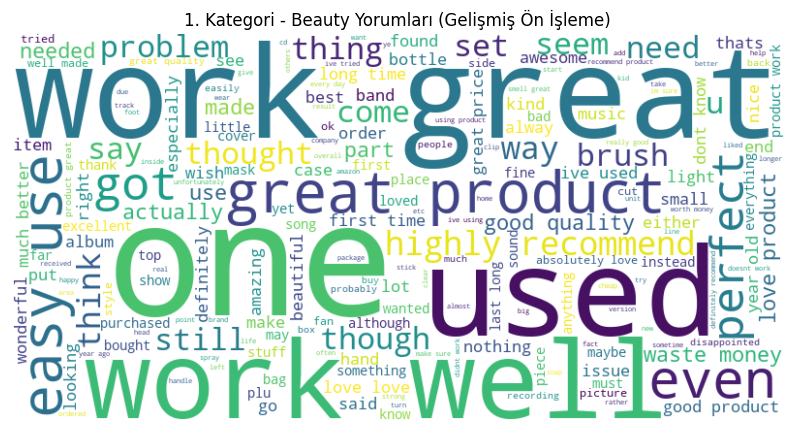

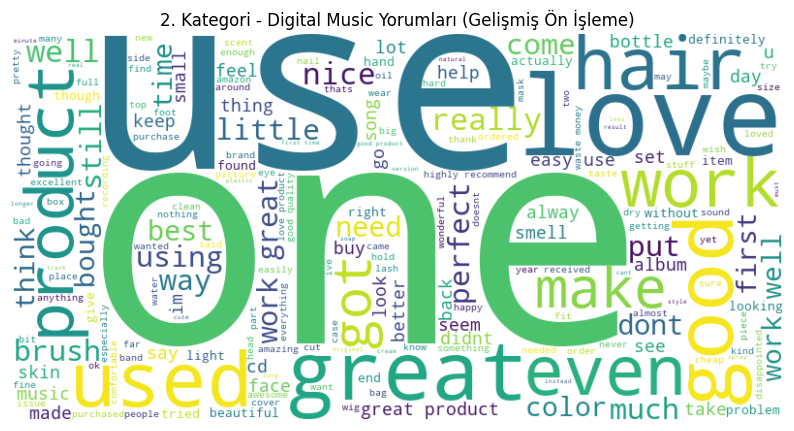

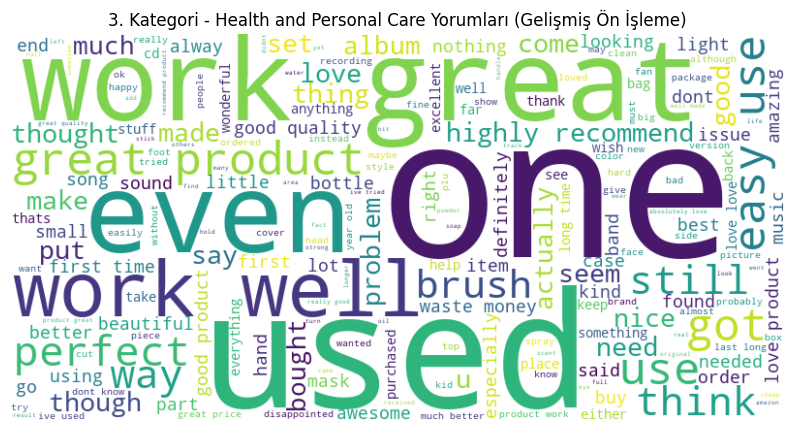

In [118]:
# Kütüphaneler
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Word Cloud Çizim Fonksiyonu
def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# 1. Veri Seti: Beauty
text_1 = df_all.iloc[:701528]['advanced_text'].str.cat(sep=' ')
plot_wordcloud(text_1, '1. Kategori - Beauty Yorumları (Gelişmiş Ön İşleme)')

# 2. Veri Seti: Digital Music
text_2 = df_all.iloc[701528:701528+130434]['advanced_text'].str.cat(sep=' ')
plot_wordcloud(text_2, '2. Kategori - Digital Music Yorumları (Gelişmiş Ön İşleme)')

# 3. Veri Seti: Health and Personal Care
text_3 = df_all.iloc[701528+130434:]['advanced_text'].str.cat(sep=' ')
plot_wordcloud(text_3, '3. Kategori - Health and Personal Care Yorumları (Gelişmiş Ön İşleme)')

1. Beauty Yorumları
	•	Öne Çıkan Kelimeler: use, work, one, great, product, brush, recommend, easy, love, even, well
	•	Anlam:
	•	Kullanıcılar ürünlerin kullanım kolaylığını (easy to use) ve etkili çalışmasını (work well) vurguluyor.
	•	Fırça (brush) kelimesi sıkça geçtiği için makyaj fırçaları, saç fırçaları gibi ürünler öne çıkmış.
	•	Olumlu geri bildirimler öne çıkarken, even kelimesinin kullanımı ürünlerin beklentileri karşıladığına dair ifadeleri gösteriyor.

2. Digital Music Yorumları
	•	Öne Çıkan Kelimeler: use, work, love, one, great, song, good, music, nice, sound
	•	Anlam:
	•	Kullanıcılar müzikle ilgili deneyimlerinde ses kalitesi (sound) ve müzik sevgisini (love music) ön plana çıkarıyor.
	•	Şarkılar (song) ve müzik (music) kelimeleri, ürünlerin kullanımının günlük hayattaki yerini gösteriyor.
	•	Yine kullanım kolaylığı (use, work) önemli bir faktör olarak dikkat çekiyor.

3. Health and Personal Care Yorumları
	•	Öne Çıkan Kelimeler: use, even, work, one, great, product, brush, recommend, good, easy
	•	Anlam:
	•	Sağlık ve kişisel bakım ürünlerinde etkililik (work well) ve kolay kullanım (easy to use) ön planda.
	•	Fırça (brush) kelimesi burada da öne çıkıyor, muhtemelen diş fırçaları, saç fırçaları veya cilt bakım fırçaları gibi ürünlerden kaynaklanıyor.
	•	Olumlu geri bildirimler (recommend, good, great) yaygın.

 Genel Değerlendirme
	•	Ortak Temalar: Tüm kategorilerde kullanım kolaylığı (use, easy) ve etkililik (work, great, well) ön planda.
	•	Kategori Bazlı Farklılıklar:
	•	Beauty: brush ve recommend kelimeleri ile ürün tavsiyeleri ve fırçalar öne çıkıyor.
	•	Digital Music: love, song, sound, music kelimeleriyle müzik dinleme deneyimi ön planda.
	•	Health and Personal Care: brush ve even kelimeleri, ürünlerin günlük kullanımdaki etkisini vurguluyor.

Sonuç olarak, kullanıcılar tüm kategorilerde kullanım kolaylığı ve ürünlerin işlevselliğinden memnun görünüyor. Word Cloud’lar, her kategorinin temel kullanım amacı ve kullanıcı beklentilerini net bir şekilde gösteriyor

Store Skorlama


,store,total_reviews,average_rating,rating_number,positive_reviews,negative_reviews,store_score
0,Harper Lee Format: Audio CD,1,4.700,131983.0,1,0,620320.100
1,J.K. Rowling Mary GrandPré Format: Audio CD,1,4.900,111099.0,1,0,544385.100
2,Donna Tartt Format: Audio CD,1,4.100,124260.0,1,0,509466.000
3,Patrick Rothfuss Format: Audio CD,2,4.700,67614.0,2,0,317785.800
4,Lee Child Format: Audio CD,2,4.400,56583.5,2,0,248967.400
5,Michael Connelly Format: Audio CD,4,4.425,49553.0,4,0,219272.025
6,George S. Clason Charles Conrad Best Succe...,2,4.700,43152.0,2,0,202814.400
7,Erin Morgenstern Format: Audio CD,1,4.400,43750.0,1,0,192500.000
8,Stephen Chbosky Format: Audio CD,3,4.700,38258.0,3,0,179812.600
9,Gregory David Roberts Format: Audio CD,1,4.600,35897.0,1,0,165126.200


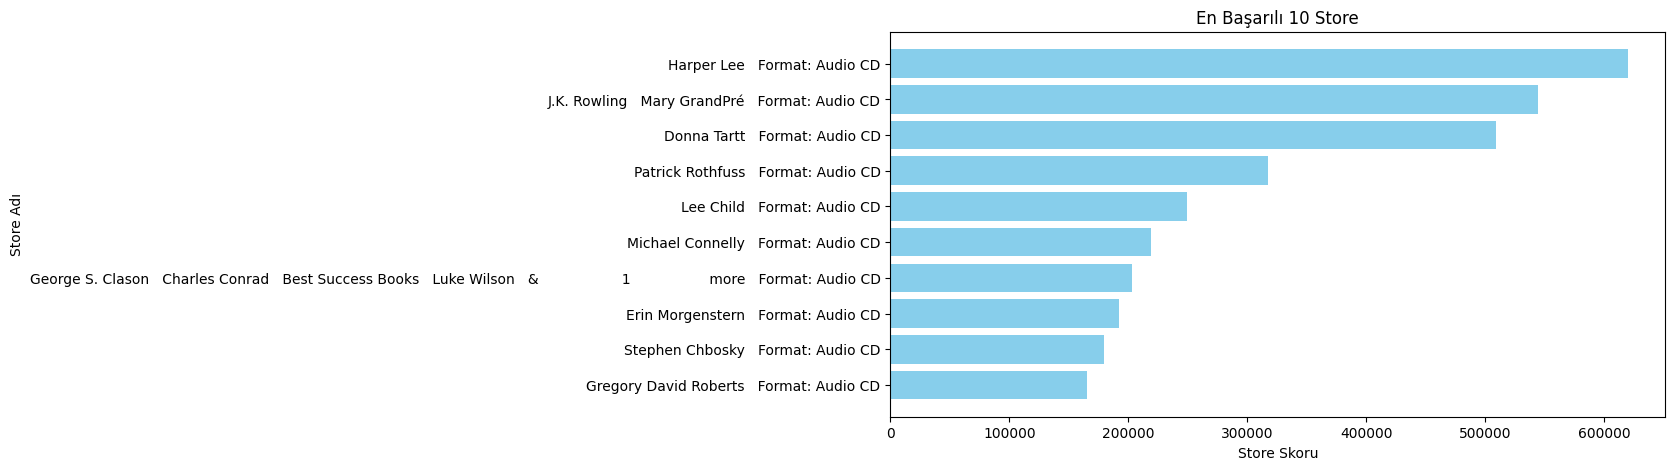

✅ Store skorları başarıyla kaydedildi!


In [178]:
# 📌 1. Verileri Yükleme ve Birleştirme
df_all = pd.concat([df_All_Beauty_Review, Digital_Music_Review, Health_and_Personal_Care_Review], ignore_index=True)

# 📌 2. Sentiment Etiketleme (Rating >= 3 → Pozitif, Aksi Takdirde Negatif)
df_all['sentiment'] = df_all['rating'].apply(lambda x: 'pozitif' if x >= 3 else 'negatif')

# 📌 3. Meta Verileriyle Birleştirme
df_beauty = df_all.merge(df_All_Beauty_Meta[['parent_asin', 'title', 'average_rating', 'rating_number', 'store']], on='parent_asin', how='left')
df_music = df_all.merge(Digital_Music_Meta[['parent_asin', 'title', 'average_rating', 'rating_number', 'store']], on='parent_asin', how='left')
df_health = df_all.merge(Health_and_Personal_Care_Meta[['parent_asin', 'title', 'average_rating', 'rating_number', 'store']], on='parent_asin', how='left')
df_all = pd.concat([df_beauty, df_music, df_health], ignore_index=True)

# 📌 4. Sentiment Analiz Sonuçlarını Hesaplama (Pozitif & Negatif Yorum Sayısı)
df_all['positive_reviews'] = (df_all['sentiment'] == 'pozitif').astype(int)
df_all['negative_reviews'] = (df_all['sentiment'] == 'negatif').astype(int)

# 📌 5. Store Skorunu Hesaplama
store_scores = df_all.groupby('store').agg(
    total_reviews=('rating', 'count'),
    average_rating=('average_rating', 'mean'),
    rating_number=('rating_number', 'mean'),
    positive_reviews=('positive_reviews', 'sum'),
    negative_reviews=('negative_reviews', 'sum')
).reset_index()

# 📌 6. Store Skor Formülünü Uygulama
store_scores['store_score'] = ((store_scores['average_rating'] * store_scores['rating_number']) * 
                               (store_scores['positive_reviews'] - store_scores['negative_reviews'])) / store_scores['total_reviews']

# 📌 7. En Başarılı 10 Store'u Listeleme
store_scores = store_scores.sort_values(by='store_score', ascending=False).reset_index(drop=True)
display(store_scores.head(10))

# 📌 8. En Başarılı 10 Store'u Grafikle Görselleştirme
plt.figure(figsize=(10, 5))
plt.barh(store_scores['store'].head(10), store_scores['store_score'].head(10), color='skyblue')
plt.xlabel("Store Skoru")
plt.ylabel("Store Adı")
plt.title("En Başarılı 10 Store")
plt.gca().invert_yaxis()
plt.show()

# 📌 9. Sonuçları Kaydetme
store_scores.to_csv('store_scores.csv', index=False)
print("✅ Store skorları başarıyla kaydedildi!")

📊 Store Skorlama Sonuçları Analizi

1️⃣ En Başarılı Mağazalar:
	•	En yüksek skoru Harper Lee Format: Audio CD almış, ardından J.K. Rowling Mary GrandPré Format: Audio CD geliyor.
	•	Listenin ilk sıralarında yer alan mağazalar genellikle yüksek rating_number (değerlendirme sayısı) ve positive_reviews (olumlu yorum) değerlerine sahip.

2️⃣ Store Skoru Hesaplaması:
	•	average_rating (ortalama puan) ve rating_number (toplam değerlendirme sayısı) büyük bir etkiye sahip.
	•	positive_reviews (olumlu yorum) arttıkça mağaza skoru yükseliyor.
	•	Negatif yorumlar sıfır olan mağazalar üst sıralara çıkmış.

3️⃣ Görselleştirme Analizi:
	•	Grafik en iyi 10 mağazayı sıralayarak başarıyı görselleştiriyor.
	•	En yüksek skoru alan mağazalar belirgin şekilde ayrışmış.
